# Predicting Lipophilicity of Molecules

In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
import deepchem as dc
from deepchem.feat.mol_graphs import ConvMol
from rdkit.Chem import AllChem, MolFromSmiles, Draw
from rdkit import Chem
from sklearn.

## Data Analysis

In [4]:
df = pd.read_csv('Lipophilicity.csv')

In [5]:
df.head()

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


In [6]:
df.describe()

,exp
count,4200.000000
mean,2.186336
std,1.203004
min,-1.500000
25%,1.410000
50%,2.360000
75%,3.100000
max,4.500000


Let's look at some molecules

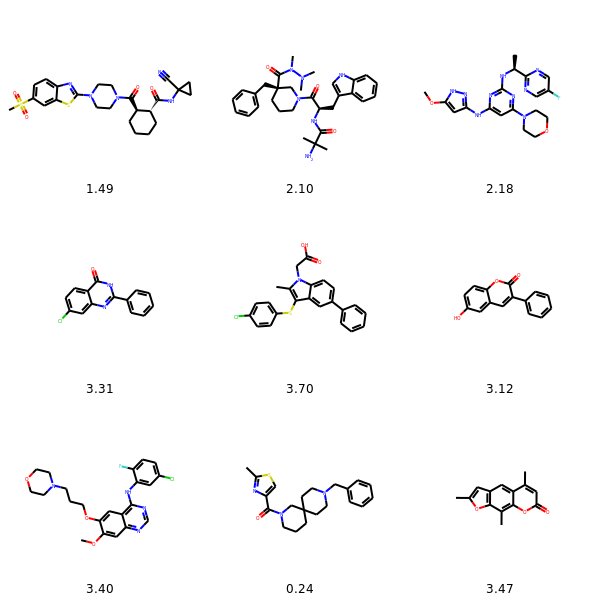

In [7]:
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
mols = []
for (ix,row) in df.sample(9).iterrows():
    m = MolFromSmiles(row.smiles)
    m.SetDoubleProp("exp", row.exp)
    mols.append(m)

img = Draw.MolsToGridImage(mols, molsPerRow=3, legends=["%.2f" % (float(m.GetProp('exp'))) for m in mols]); img

# Graph Embedding

Next, the molecules will be represented by graphs. The graphs will be embedded such that they can be used in a deep learning model for Lipophilicity predictions.

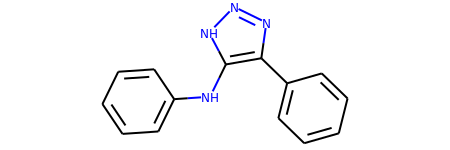

In [250]:
m = MolFromSmiles(df.iloc[1337].smiles)
m

In [251]:
from rdkit.Chem import rdmolops
import networkx as nx 
import matplotlib.pyplot as plt
AllChem.Compute2DCoords(m)
admatrix = rdmolops.GetAdjacencyMatrix( m )

In [252]:
nx_graph = nx.from_numpy_matrix(admatrix)

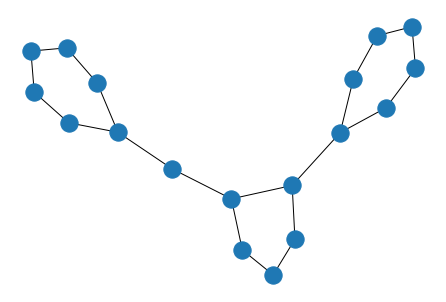

In [253]:
nx.draw(nx_graph)

Looks pretty sweet! Let's see if we can embed this graph representation

In [254]:
from karateclub import Graph2Vec
g2v  = Graph2Vec()
g2v.fit([nx_graph])
g2v.get_embedding()

array([[-0.00299004, -0.00321894, -0.00015839,  0.00314686, -0.00236089,
         0.00104585, -0.00234593,  0.00051356,  0.00208052, -0.00326612,
         0.00223004,  0.00103003, -0.00207647,  0.00124784,  0.00172796,
        -0.00354546, -0.0024221 ,  0.00247186, -0.00044375,  0.0010865 ,
         0.00074129, -0.00250586,  0.00321635,  0.00150343, -0.00362363,
         0.00106635,  0.00014555, -0.00152251, -0.00077438,  0.00048346,
        -0.00074688,  0.00203126,  0.00088274, -0.00134888,  0.00390561,
        -0.00210841,  0.00315848, -0.00356465,  0.00040528, -0.00375233,
        -0.00060841, -0.00267055, -0.00326018, -0.00209995, -0.00098327,
         0.00309394,  0.00260186, -0.00308601, -0.00299805, -0.00199068,
         0.00109133, -0.00350984, -0.00280095,  0.00030697,  0.00236574,
         0.00292634, -0.00354072, -0.00343076, -0.00270031,  0.00324108,
         0.0006622 ,  0.00349947, -0.00016165,  0.00274851,  0.00349275,
        -0.00031037,  0.00213059,  0.00034318, -0.0

## Augmenting dataset with morgan fingerprints

In [389]:
fps = []
for ix,row in df.iterrows():
    m = MolFromSmiles(row.smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(m, useChirality=True, radius=2, nBits=128)
    fps.append(fp)
fps = np.array(fps)
fps

array([[0, 0, 1, ..., 1, 0, 1],
       [1, 0, 0, ..., 1, 0, 0],
       [1, 1, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 1],
       [1, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

## Augmenting dataset with embedding

In [417]:
embedding_dimensions = 128
g2v = Graph2Vec(dimensions=embedding_dimensions, seed=42)
nx_graphs = []

for ix,row in df.iterrows():
    m = MolFromSmiles(row.smiles)
    AllChem.Compute2DCoords(m)
    admatrix = rdmolops.GetAdjacencyMatrix( m )
    nx_graph = nx.from_numpy_matrix(admatrix)
    nx_graphs.append(nx_graph)
    
g2v.fit(nx_graphs)
embedding = g2v.get_embedding()
embedding =  np.array(embedding)

In [425]:
d_names = ['emb_' + str(i) for i in range(embedding_dimensions)]
df_emb = pd.DataFrame(embedding, columns=d_names)
df_exp = pd.DataFrame(df['exp'])
df_combined = pd.concat([df_exp, df_emb], axis=1)
X = df_combined.iloc[:,1:].to_numpy()
y = df_combined.iloc[:, 0].to_numpy()
df_combined

,exp,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,3.54,0.034134,0.027644,-0.012245,0.012882,-0.031407,-0.039891,0.028246,-0.025022,-0.008415,...,-0.043733,-0.016836,0.072619,0.078680,-0.010295,0.074896,0.087125,0.066116,0.013294,-0.024197
1,-1.18,0.056104,0.050616,-0.022269,0.015746,-0.043418,-0.058462,0.048338,-0.042056,-0.013055,...,-0.064607,-0.025778,0.117635,0.118407,-0.017764,0.122966,0.132050,0.102765,0.015019,-0.036180
2,3.69,0.050082,0.036255,-0.014377,0.015405,-0.037639,-0.047665,0.040264,-0.028683,-0.008960,...,-0.053128,-0.023163,0.095142,0.094686,-0.014293,0.095660,0.101862,0.084963,0.014837,-0.023015
3,3.37,0.041557,0.034543,-0.013568,0.007241,-0.034342,-0.042212,0.033150,-0.028185,-0.007498,...,-0.044807,-0.020480,0.083228,0.086032,-0.015423,0.085600,0.091580,0.068534,0.014963,-0.020918
4,3.10,0.047618,0.034187,-0.012189,0.015146,-0.034085,-0.051528,0.034584,-0.031404,-0.011736,...,-0.046298,-0.025262,0.088703,0.094624,-0.015182,0.094378,0.103565,0.083474,0.014228,-0.026286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,3.85,0.038466,0.029435,-0.013780,0.013785,-0.030992,-0.042298,0.034128,-0.026105,-0.010356,...,-0.040926,-0.014220,0.075282,0.076311,-0.010761,0.076378,0.087903,0.067650,0.014005,-0.024838
4196,3.21,0.036461,0.030527,-0.014875,0.010669,-0.028054,-0.037773,0.033563,-0.025463,-0.014257,...,-0.041189,-0.020440,0.080953,0.079019,-0.010141,0.078305,0.089475,0.069245,0.008773,-0.021981
4197,2.10,0.033310,0.030929,-0.015272,0.008512,-0.026838,-0.038701,0.028599,-0.028300,-0.011944,...,-0.036532,-0.013954,0.072347,0.075720,-0.008939,0.078488,0.079412,0.063452,0.008032,-0.019228
4198,2.65,0.043366,0.030183,-0.013449,0.008459,-0.031204,-0.041005,0.032142,-0.030144,-0.011659,...,-0.047273,-0.016489,0.082811,0.078918,-0.011217,0.084091,0.092726,0.072549,0.013726,-0.026495


# Training machine learning model for Lipophilicity prediction

In [430]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
import math
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [434]:
lr = LinearRegression(normalize=False)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
rmse

1.231839025089365

## Only using Morgan fingerprints

In [435]:
fp_d_names = ['fp_' + str(i) for i in range(embedding_dimensions)]
d_names = ['emb_' + str(i) for i in range(embedding_dimensions)]
df_fps = pd.DataFrame(fps, columns=fp_d_names)
df_emb = pd.DataFrame(g2v.get_embedding(), columns=d_names)
df_exp = pd.DataFrame(df['exp'])
df_combined = pd.concat([df_exp, df_fps], axis=1)
X = df_combined.iloc[:,1:].to_numpy()
y = df_combined.iloc[:, 0].to_numpy()

In [436]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
rmse

1.100868398786017